<a href="https://colab.research.google.com/github/Aleksandr62aa/Test_task/blob/main/FC_NN_diabetes_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Diabetes**

**Dataset Diabetes**

**Importing libraries**

In [97]:
!pip install torchinfo

In [99]:
import torch
import random
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.datasets
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import csv
import cv2
from tqdm import tqdm

# Fixed seed
random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)
torch.backends.cudnn.deterministic = True

In [101]:
# Hyperparameters

# Training
num_epochs = 80
learning_rate = 1.0e-3
batch_size = 614

# Dataset
train_ratio = 0.8

# Model
input_size = 8
n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
classes = 2

**Train Test dataset**

In [102]:
class CustomDataset(Dataset):
    def __init__(self, tile_name, train=True, train_ratio=0.8):
        self.tile_name = tile_name
        self.train = train
        self.train_ratio = train_ratio
        self.load_data()

    def load_data(self):
        # read csv file
        data_frame = pd.read_csv(self.tile_name)
        x_np = data_frame.iloc[:,:-1].values
        y_np = data_frame.iloc[:,-1].values

        # Applying StandardScaler
        scaler = StandardScaler()
        x_scaler = scaler.fit_transform(x_np)

        # converting to torch tensors
        x_tensor = torch.tensor(x_scaler, dtype=torch.float32)
        y_tensor = torch.tensor(y_np, dtype=torch.int64)

        # Define Split Ratios
        train_size = int(train_ratio * len(y_tensor))

        if self.train:
            self.X = x_tensor[:train_size]
            self.y = y_tensor[:train_size]
        else:
            self.X = x_tensor[train_size:]
            self.y = y_tensor[train_size:]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [103]:
train_dataset = CustomDataset('diabetes.csv', train=True)
test_dataset = CustomDataset('diabetes.csv', train=False)

In [104]:
print(len(train_dataset), len(test_dataset))
print(train_dataset[0])
print(test_dataset[0])

614 154
(tensor([ 0.6399,  0.8483,  0.1496,  0.9073, -0.6929,  0.2040,  0.4685,  1.4260]), tensor(1))
(tensor([2.1248, 0.5354, 0.2530, 0.3427, 0.5574, 0.5213, 0.2571, 1.4260]), tensor(1))


In [105]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [106]:
for batch in train_dataloader :
    X_batch, y_batch = batch
    print( y_batch.sum())

tensor(213)


In [107]:
print(len(train_dataset), len(train_dataloader))
print(len(test_dataset), len(test_dataloader))

614 1
154 1


In [108]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**Model FC NN**

In [109]:
class DiabedNet(torch.nn.Module):
    def __init__(self, input_size):
        # super().__init__()
        super(DiabedNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, n_hidden_1)
        self.fc2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = torch.nn.Linear(n_hidden_2, n_hidden_3)
        self.fc4 = torch.nn.Linear(n_hidden_3, classes)
        self.relu = torch.nn.ReLU()
        # self.drop_out = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [110]:
model = DiabedNet(input_size).to(device)

In [111]:
summary(model, input_size=(1, 8))

Layer (type:depth-idx)                   Output Shape              Param #
DiabedNet                                [1, 2]                    --
├─Linear: 1-1                            [1, 64]                   576
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 16]                   528
├─ReLU: 1-6                              [1, 16]                   --
├─Linear: 1-7                            [1, 2]                    34
Total params: 3,218
Trainable params: 3,218
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

**Loss function**

In [112]:
class_weights = torch.tensor([0.3, 0.7])  # веса
loss = torch.nn.CrossEntropyLoss(class_weights)

**Optimizer**

In [113]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Training procedure**

In [114]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in tqdm(range(num_epochs)):   # цикл обучения по эпохам
    running_loss_train = 0.
    running_acc_train = 0.
    model.train()

    for batch in train_dataloader:# цикл обучения по бачам
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = model.forward(X_batch)

        # loss функция
        loss_train = loss(y_preds, y_batch)

        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.cpu().detach().numpy()
        running_acc_train += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()
    epoch_loss = running_loss_train/ len(train_dataloader)
    train_loss_history.append(epoch_loss)

    epoch_acc = running_acc_train/len(train_dataloader)
    train_accuracy_history .append(epoch_acc)

    # тестирование модели
    running_loss_test = 0.
    running_acc_test = 0.
    model.eval()

    for batch in test_dataloader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = model.forward(X_batch)

        running_loss_test += loss(y_preds, y_batch).cpu().detach().numpy()
        running_acc_test += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()

    epoch_loss = running_loss_test/len(test_dataloader)
    test_loss_history.append(epoch_loss)

    epoch_acc = running_acc_test/len(test_dataloader)
    test_accuracy_history.append(epoch_acc)


100%|██████████| 80/80 [00:01<00:00, 44.08it/s]


In [92]:
# # Evaluate the model using PyTorch

# y_true = []
# y_pred = []
# model.eval()

# for batch in test_dataloader:
#     X_batch, y_batch = batch
#     X_batch = X_batch.to(device)
#     outputs = model(X_batch)
#     _, y_preds = torch.max(outputs, dim=1)
#     y_pred.extend(y_preds.cpu().numpy())
#     y_true.extend(y_batch.cpu().numpy())

# # Convert lists to tensors for calculation
# y_true_tensor = torch.tensor(y_true)
# y_pred_tensor = torch.tensor(y_pred)

# # Calculating precision, recall, and F1 score using PyTorch
# TP = ((y_pred_tensor == 1) & (y_true_tensor == 1)).sum().item()
# TN = ((y_pred_tensor == 0) & (y_true_tensor == 0)).sum().item()
# FP = ((y_pred_tensor == 1) & (y_true_tensor == 0)).sum().item()
# FN = ((y_pred_tensor == 0) & (y_true_tensor == 1)).sum().item()

# accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0

# precision_0 = TN / (TN + FN) if TN + FN > 0 else 0
# precision_1 = TP / (TP + FP) if TP + FP > 0 else 0
# recall_0 = TN / (TN + FP) if TN + FP > 0 else 0
# recall_1 = TP / (TP + FN) if TP + FN > 0 else 0

# f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
# f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

# print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision_0: {precision_0:.4f}, Precision_1: {precision_1:.4f}')
# print(f'Recall_0: {recall_0:.4f}, Recall_1: {recall_1:.4f}')
# print(f'F1-Score_0: {f1_0:.4f}, F1-Score_1: {f1_1:.4f}')

In [115]:
y_true = []
y_pred = []
model.eval()

for batch in test_dataloader:
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    outputs = model(X_batch)
    _, y_preds = torch.max(outputs, dim=1)
    y_pred.extend(y_preds.cpu().detach().numpy())
    y_true.extend(y_batch.cpu().detach().numpy())

print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
print(f'\nClassification Report:\n {classification_report(y_true, y_pred)}')

Accuracy: 0.7857

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83        99
           1       0.67      0.78      0.72        55

    accuracy                           0.79       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.80      0.79      0.79       154



**Result test**

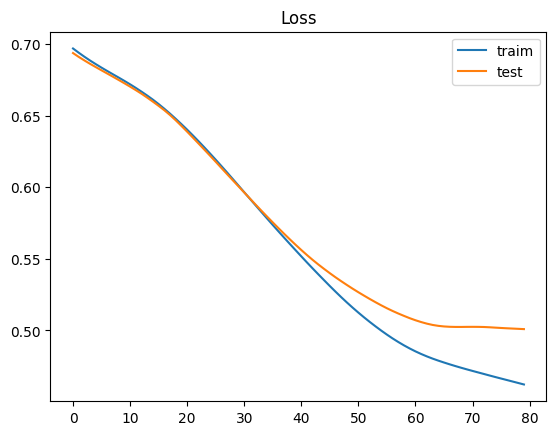

In [116]:
plt.plot(train_loss_history, label='traim')
plt.plot(test_loss_history, label='test')
plt.legend(loc='best')
plt.title('Loss');

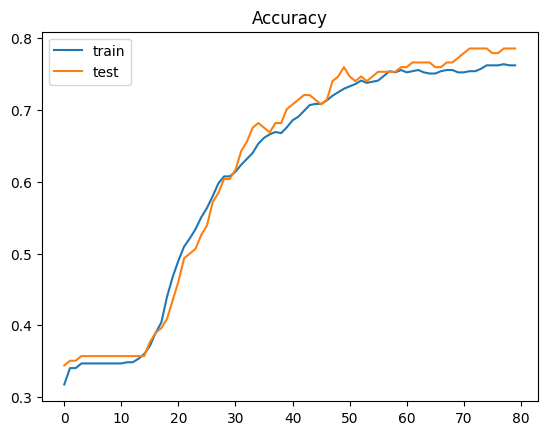

In [117]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend(loc='best')
plt.title('Accuracy');

In [119]:
# Save the model state
st = model.state_dict()
torch.save(st, 'diab_model.tar')
# torch.save(st, 'diab_model.pth')